## Data Preview 1 mock data collections

This notebook presents two Data Preview 1 (DP1) mock data collections available in the HATS format. We will walk you through on how to load, preview and work with this data in preparation for the official data release by the Rubin Observatory.

#### How was this data generated?

The dummy data was generated with a simple [Python script](https://github.com/lsst-sitcom/linccf/blob/main/internal/LSSTCam_init/Mock_DP1_generation.ipynb) that randomizes fields according to partition-level min/max-values.

### Table of contents

- Which observatory data products were imported?
- How to visualize the distribution of the data?
- How to visualize the catalog metadata and schema?
- How to load individual files with a parquet reader?
- How to work with the full catalog with LSDB?

In [ ]:
%pip install lsdb --quiet

In [2]:
from upath import UPath
base_path = UPath("https://data.lsdb.io/hats/mock_dp1")

#### Which observatory data products were imported?

The Data Preview 1 mock data collections were generated based on [DRP v29_0_0_rc5](https://rubinobs.atlassian.net/browse/DM-49865). They contain **DUMMY** data in the same format and with the same data types as the upcoming Rubin Data Preview 1 HATS catalogs.

The available collections are `dia_object_collection` and `object_collection`.

```text
mock_dp1
├── dia_object_collection
│   ├── collection.properties
│   ├── dia_object_lc
│   ├── dia_object_lc_5arcs
│   └── dia_object_lc_diaObjectId
└── object_collection
    ├── collection.properties
    ├── object_lc
    ├── object_lc_5arcs
    └── object_lc_objectId
```

Each collection contains a main object catalog with time-domain data, and two auxiliary catalogs: a margin cache catalog and an index catalog. The data of interest resides in the main catalogs, named *dia_object_lc* and *object_lc*, and they contain light curve information.

- `dia_object_lc` contains data obtained from difference imaging. To create this catalog we joined the data for each *dia_object* with the respective detections in *dia_source* and *dia_forced_source*.

- `object_lc` contains data obtained from science imaging. To create this catalog we joined the data for each *object* with the respective detections in *forced_source*. There is no association between *source* and *object*.

Powered by [**nested-pandas**](https://nested-pandas.readthedocs.io/en/stable/), the objects' light curve information can be loaded, previewed and processed within a single data structure.

#### How to visualize the distribution of the data?

The metadata allows us to visualize the distribution of the data quickly and without any compute. Using the `hats` package we can plot the HEALPix distribution in a mollweide view as well as observe a higher order Multi-Order-Coverage (MOC) map of where the data is in the sky.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - object_lc'}>)

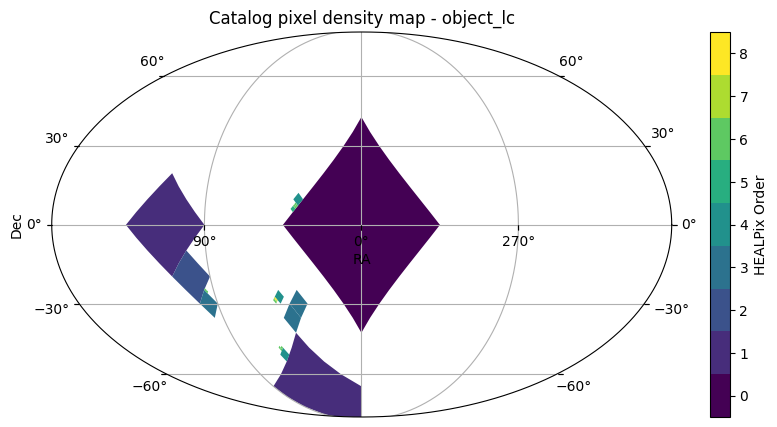

In [3]:
import hats
object_lc = hats.read_hats(base_path / "object_collection").main_catalog
object_lc.plot_pixels()

(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Coverage MOC of object_lc'}>)

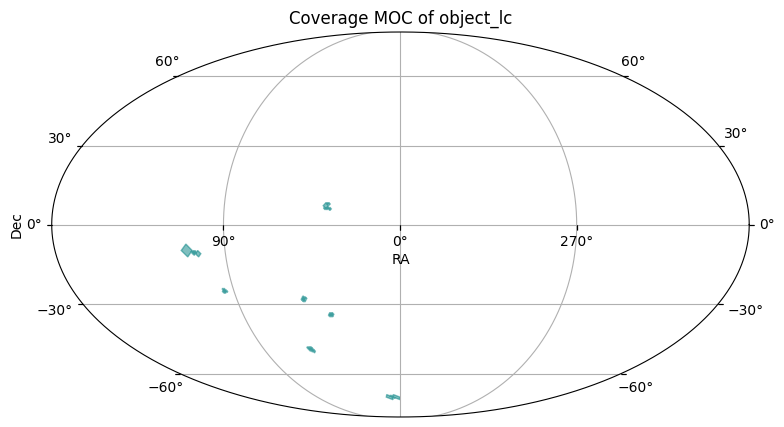

In [4]:
object_lc.plot_moc()

#### How to visualize the catalog metadata and schema?

The catalogs' metadata and schema (columns and their data types) can be found in their HATS object.

In [ ]:
# The catalog's arrow schema
object_lc.original_schema

objectId: int64
refFwhm: float
shape_flag: bool
parentObjectId: int64
x: double
y: double
xErr: float
yErr: float
shape_yy: float
shape_xx: float
shape_xy: float
coord_ra: double
coord_dec: double
coord_raErr: float
coord_decErr: float
tract: int64
patch: int64
detect_isIsolated: bool
u_psfFlux: float
u_psfFluxErr: float
u_kronFlux: float
u_kronFluxErr: float
u_kronRad: float
g_psfFlux: float
g_psfFluxErr: float
g_kronFlux: float
g_kronFluxErr: float
g_kronRad: float
r_psfFlux: float
r_psfFluxErr: float
r_kronFlux: float
r_kronFluxErr: float
r_kronRad: float
i_psfFlux: float
i_psfFluxErr: float
i_kronFlux: float
i_kronFluxErr: float
i_kronRad: float
z_psfFlux: float
z_psfFluxErr: float
z_kronFlux: float
z_kronFluxErr: float
z_kronRad: float
y_psfFlux: float
y_psfFluxErr: float
y_kronFlux: float
y_kronFluxErr: float
y_kronRad: float
u_psfMag: float
u_psfMagErr: float
u_kronMag: float
u_kronMagErr: float
g_psfMag: float
g_psfMagErr: float
g_kronMag: float
g_kronMagErr: float
r_psfMag: fl

In [ ]:
# Other provenance information
dict(object_lc.catalog_info)

{'catalog_name': 'object_lc',
 'catalog_type': 'object',
 'total_rows': 2284295,
 'ra_column': 'coord_ra',
 'dec_column': 'coord_dec',
 'default_columns': None,
 'primary_catalog': None,
 'margin_threshold': None,
 'primary_column': None,
 'primary_column_association': None,
 'join_catalog': None,
 'join_column': None,
 'join_column_association': None,
 'contains_leaf_files': None,
 'indexing_column': None,
 'extra_columns': None,
 'npix_suffix': '.parquet',
 'hats_max_rows': '270888',
 'hats_order': '6',
 'moc_sky_fraction': '0.13696',
 'hats_builder': 'hats-import v0.5.0',
 'hats_creation_date': '2025-04-09T18:00UTC',
 'hats_estsize': '522346',
 'hats_release_date': '2024-09-18',
 'hats_version': 'v0.1'}

#### How to load individual files with a parquet reader?

We can load individual data files with any parquet-compatible file reader (e.g. `pyarrow.parquet`).

In [ ]:
# Grab a single file from the object catalog
single_parquet = base_path / "object_collection/object_lc/dataset/Norder=3/Dir=0/Npix=562.parquet"

In [8]:
import fsspec
import pyarrow.parquet as pq

# With the help of fsspec we can read using HTTPS
with fsspec.open(single_parquet.path, "rb") as f:
    partition = pq.read_table(f).to_pandas()
partition.head()

,objectId,refFwhm,shape_flag,parentObjectId,x,y,xErr,yErr,shape_yy,shape_xx,...,z_psfMag,z_psfMagErr,z_kronMag,z_kronMagErr,y_psfMag,y_psfMagErr,y_kronMag,y_kronMagErr,objectForcedSource,_healpix_29
0,1771183332596395873,1.274454,False,1744348857737948012,13606.054868,23789.014637,4193.455078,4857.621582,275.843292,121.994873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'parentObjectId': [0], 'coord_ra': [40.373968...",2531149077845991875
1,1820912740260164671,1.008481,False,1761631044224072329,15712.628579,25823.549748,2218.592529,5975.993164,381.416138,642.205811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'parentObjectId': [0], 'coord_ra': [38.425171...",2531163502938224027
2,1822322001564778618,0.655067,True,857990465101314905,7759.116895,7789.053409,866.714417,7731.217773,189.271454,63.975182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'parentObjectId': [0], 'coord_ra': [39.868242...",2531079320757574562
3,1831194790106876628,0.995587,False,618909296268633109,21455.980412,22294.202580,2734.268311,6110.421875,57.987934,494.740723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'parentObjectId': [0], 'coord_ra': [39.041313...",2531056755597495889
4,1854908679430673795,0.759513,True,623234076949560343,14172.638646,16428.004292,5996.293457,5931.818848,756.892761,429.038452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'parentObjectId': [0], 'coord_ra': [38.509513...",2531045541154664018


There is a nested column with light curve information (*objectForcedSource*). We recommend **nested-pandas** for reading files in this format.

In [9]:
from nested_pandas import read_parquet
nested_df = read_parquet(single_parquet)
nested_df.head()

objectId   refFwhm shape_flag       parentObjectId  \
0  1771183332596395873  1.274454      False  1744348857737948012   
1  1820912740260164671  1.008481      False  1761631044224072329   
2  1822322001564778618  0.655067       True   857990465101314905   
3  1831194790106876628  0.995587      False   618909296268633109   
4  1854908679430673795  0.759513       True   623234076949560343   

              x             y         xErr         yErr    shape_yy  \
0  13606.054868  23789.014637  4193.455078  4857.621582  275.843292   
1  15712.628579  25823.549748  2218.592529  5975.993164  381.416138   
2   7759.116895   7789.053409   866.714417  7731.217773  189.271454   
3  21455.980412   22294.20258  2734.268311  6110.421875   57.987934   
4  14172.638646  16428.004292  5996.293457  5931.818848  756.892761   

     shape_xx  ...  z_kronMag  z_kronMagErr  y_psfMag  y_psfMagErr  y_kronMag  \
0  121.994873  ...       <NA>          <NA>      <NA>         <NA>       <NA>   
1  642.205811  ...       <NA>          <NA>      <NA>         <NA>       <NA>   
2   63.975182  ...       <NA>          <NA>      <NA>         <NA>       <NA>   
3  494.740723  ...       <NA>          <NA>      <NA>         <NA>       <NA>   
4  429.038452  ...       <NA>          <NA>      <NA>         <NA>       <NA>   

   y_kronMagErr                                 objectForcedSource  \
0          <NA>  [{parentObjectId: 0, coord_ra: 40.373969, coor...   
1          <NA>  [{parentObjectId: 0, coord_ra: 38.425171, coor...   
2          <NA>  [{parentObjectId: 0, coord_ra: 39.868242, coor...   
3          <NA>  [{parentObjectId: 0, coord_ra: 39.041314, coor...   
4          <NA>  [{parentObjectId: 0, coord_ra: 38.509514, coor...   

           _healpix_29  Norder  Dir  
0  2531149077845991875       3    0  
1  2531163502938224027       3    0  
2  2531079320757574562       3    0  
3  2531056755597495889       3    0  
4  2531045541154664018       3    0  

[5 rows x 76 columns]

#### How to work with the full catalog with LSDB?

Loading, previewing and creating workflows with HATS data is much simpler with [LSDB](https://docs.lsdb.io/en/stable/).

In [10]:
%%time
import lsdb
# Read the catalog metadata and visualize it in the notebook
object_lc = lsdb.read_hats(base_path / "object_collection")
object_lc

CPU times: user 725 ms, sys: 81.7 ms, total: 807 ms
Wall time: 3.16 s


,objectId,refFwhm,shape_flag,parentObjectId,x,y,xErr,yErr,shape_yy,shape_xx,shape_xy,coord_ra,coord_dec,coord_raErr,coord_decErr,tract,patch,detect_isIsolated,u_psfFlux,u_psfFluxErr,u_kronFlux,u_kronFluxErr,u_kronRad,g_psfFlux,g_psfFluxErr,g_kronFlux,g_kronFluxErr,g_kronRad,r_psfFlux,r_psfFluxErr,r_kronFlux,r_kronFluxErr,r_kronRad,i_psfFlux,i_psfFluxErr,i_kronFlux,i_kronFluxErr,i_kronRad,z_psfFlux,z_psfFluxErr,z_kronFlux,z_kronFluxErr,z_kronRad,y_psfFlux,y_psfFluxErr,y_kronFlux,y_kronFluxErr,y_kronRad,u_psfMag,u_psfMagErr,u_kronMag,u_kronMagErr,g_psfMag,g_psfMagErr,g_kronMag,g_kronMagErr,r_psfMag,r_psfMagErr,r_kronMag,r_kronMagErr,i_psfMag,i_psfMagErr,i_kronMag,i_kronMagErr,z_psfMag,z_psfMagErr,z_kronMag,z_kronMagErr,y_psfMag,y_psfMagErr,y_kronMag,y_kronMagErr,objectForcedSource
npartitions=39,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 5, Pixel: 32",int64[pyarrow],float[pyarrow],bool[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou..."
"Order: 6, Pixel: 136",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 2247",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 562",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [11]:
%%time
# Look at the first 5 rows
object_lc.head()

CPU times: user 371 ms, sys: 67.4 ms, total: 438 ms
Wall time: 1.36 s


objectId   refFwhm shape_flag  \
_healpix_29                                                  
9206805531220616  4601903407187192593   1.06296       True   
9208577312695950  4601844406312166617  1.060362       True   
9198237522431349  4601905423160085759  0.981413       True   
9195465926106561  4602077506480630149  0.993567      False   
9194088496988887  4601846701952934704  0.847918      False   

                       parentObjectId             x            y         xErr  \
_healpix_29                                                                     
9206805531220616  4373144763361278125  18449.882471  2670.666404   788.492615   
9208577312695950  2073704554273386752   4510.747651  5237.547781  1530.578125   
9198237522431349  3189492688657300711  22059.547855  6426.537449  1524.717041   
9195465926106561  1500928140292944109  26522.766297  7646.513905  1589.144897   
9194088496988887  1587191867895315869  10856.924149   6802.60546   799.278076   

                         yErr    shape_yy    shape_xx  ...  i_kronMagErr  \
_healpix_29                                            ...                 
9206805531220616  1246.001587  355.328949   48.932098  ...      0.401209   
9208577312695950   244.235977   83.241791  355.827484  ...      3.293537   
9198237522431349   378.292725  144.031723  225.772522  ...      2.413962   
9195465926106561    76.395653  111.523758  347.293427  ...      2.861533   
9194088496988887   484.426147  240.183502   18.813662  ...      3.938737   

                   z_psfMag  z_psfMagErr  z_kronMag  z_kronMagErr  y_psfMag  \
_healpix_29                                                                   
9206805531220616  18.030441     1.851072  28.480227      2.522793      <NA>   
9208577312695950  26.544527     3.154085  18.760015      0.981723      <NA>   
9198237522431349  31.003269     3.327162  17.538736      4.280602      <NA>   
9195465926106561  29.332096     2.481468  18.675444      3.063761      <NA>   
9194088496988887  28.486269     2.471767  27.912544      4.390429      <NA>   

                  y_psfMagErr y_kronMag  y_kronMagErr  \
_healpix_29                                             
9206805531220616         <NA>      <NA>          <NA>   
9208577312695950         <NA>      <NA>          <NA>   
9198237522431349         <NA>      <NA>          <NA>   
9195465926106561         <NA>      <NA>          <NA>   
9194088496988887         <NA>      <NA>          <NA>   

                                                 objectForcedSource  
_healpix_29                                                          
9206805531220616  [{parentObjectId: 0, coord_ra: 38.952892, coor...  
9208577312695950  [{parentObjectId: 0, coord_ra: 38.780028, coor...  
9198237522431349  [{parentObjectId: 0, coord_ra: 38.574508, coor...  
9195465926106561  [{parentObjectId: 0, coord_ra: 38.535381, coor...  
9194088496988887  [{parentObjectId: 0, coord_ra: 38.800253, coor...  

[5 rows x 73 columns]

A common use case is applying a user-defined function over each partition (pixel) of the catalog:

In [12]:
def run_per_partition(df, pixel):
    """This code runs once per partition (pixel)."""
    # Do some processing on the dataframe...
    # For example, let's add two new columns with the pixel order and number
    df["Norder"] = pixel.order
    df["Npix"] = pixel.pixel
    return df

# This function call is lazily evaluated
my_object_lc = object_lc.map_partitions(run_per_partition, include_pixel=True)

The computation is triggered by calling `.compute()`. Here we use `.head()` to only get the first 5 rows.

In [13]:
my_object_lc.head()

objectId   refFwhm shape_flag  \
_healpix_29                                                  
9206805531220616  4601903407187192593   1.06296       True   
9208577312695950  4601844406312166617  1.060362       True   
9198237522431349  4601905423160085759  0.981413       True   
9195465926106561  4602077506480630149  0.993567      False   
9194088496988887  4601846701952934704  0.847918      False   

                       parentObjectId             x            y         xErr  \
_healpix_29                                                                     
9206805531220616  4373144763361278125  18449.882471  2670.666404   788.492615   
9208577312695950  2073704554273386752   4510.747651  5237.547781  1530.578125   
9198237522431349  3189492688657300711  22059.547855  6426.537449  1524.717041   
9195465926106561  1500928140292944109  26522.766297  7646.513905  1589.144897   
9194088496988887  1587191867895315869  10856.924149   6802.60546   799.278076   

                         yErr    shape_yy    shape_xx  ...  z_psfMagErr  \
_healpix_29                                            ...                
9206805531220616  1246.001587  355.328949   48.932098  ...     1.851072   
9208577312695950   244.235977   83.241791  355.827484  ...     3.154085   
9198237522431349   378.292725  144.031723  225.772522  ...     3.327162   
9195465926106561    76.395653  111.523758  347.293427  ...     2.481468   
9194088496988887   484.426147  240.183502   18.813662  ...     2.471767   

                  z_kronMag  z_kronMagErr  y_psfMag  y_psfMagErr  y_kronMag  \
_healpix_29                                                                   
9206805531220616  28.480227      2.522793      <NA>         <NA>       <NA>   
9208577312695950  18.760015      0.981723      <NA>         <NA>       <NA>   
9198237522431349  17.538736      4.280602      <NA>         <NA>       <NA>   
9195465926106561  18.675444      3.063761      <NA>         <NA>       <NA>   
9194088496988887  27.912544      4.390429      <NA>         <NA>       <NA>   

                  y_kronMagErr  \
_healpix_29                      
9206805531220616          <NA>   
9208577312695950          <NA>   
9198237522431349          <NA>   
9195465926106561          <NA>   
9194088496988887          <NA>   

                                                 objectForcedSource  Norder  \
_healpix_29                                                                   
9206805531220616  [{parentObjectId: 0, coord_ra: 38.952892, coor...       5   
9208577312695950  [{parentObjectId: 0, coord_ra: 38.780028, coor...       5   
9198237522431349  [{parentObjectId: 0, coord_ra: 38.574508, coor...       5   
9195465926106561  [{parentObjectId: 0, coord_ra: 38.535381, coor...       5   
9194088496988887  [{parentObjectId: 0, coord_ra: 38.800253, coor...       5   

                  Npix  
_healpix_29             
9206805531220616    32  
9208577312695950    32  
9198237522431349    32  
9195465926106561    32  
9194088496988887    32  

[5 rows x 75 columns]

Keep in mind that `.compute()` will bring the full result of the catalog into memory. 

If your catalog is too big to fit in memory or you wish to reuse it later, call `to_hats` and save it to disk:

```python
my_object_lc.to_hats("path_to_my_catalog", catalog_name="name_for_my_catalog")
```